# Non normal network and transient response
## Introduction: Where eigen-analysis breaks down

Consider an evolution equation of the form $$\dot{\boldsymbol{x}}=\boldsymbol{A}\boldsymbol{x}$$ where $$\boldsymbol{A}=\begin{pmatrix}-1 & 500\\
0 & -2
\end{pmatrix}$$

The eigenvalues are clearly $-1,-2$. However, for some initial conditions this system will still grow massively in amplitude

In [ ]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [1]:
import numpy as np
import scipy.linalg as spl
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from pyross.contactMatrix import characterise_transient

Text(0, 0.5, '$|x|/|x_0|$')

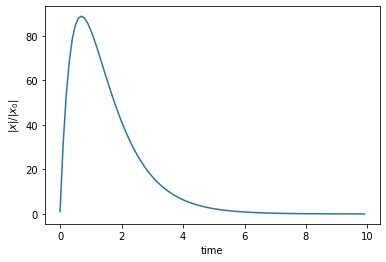

In [2]:
A = np.array([[-1,500],[0,-2]])
x0 = [1,1]
tf = 10
def linear_system(t, x): return A@x

ivp = solve_ivp(linear_system, (0,tf), x0, t_eval=np.arange(0,tf,.1))
plt.plot(ivp.t,spl.norm(ivp.y.T, axis=1)/spl.norm(x0))
plt.xlabel("time")
plt.ylabel("$|x|/|x_0|$")

Here we see a massive amplification of the initial conditions, although the eigenvalues would suggest exponential decay. What is happening? The answer is that any non-normal matrix $\boldsymbol{A}$ (such that $\boldsymbol{A}\boldsymbol{A}^T \neq \boldsymbol{A}^T\boldsymbol{A}$) will give a transient response as the system relaxes back down to the (non-orthogonal) eigendirection.

Such transients can be classified in terms of the spectral abcissa (eigenvalue(s) with maximal real component) $\alpha (\boldsymbol{A})$ which determines the long term behaviour, the numerical abcissa (eigenvalues of $\frac{1}{2}(\boldsymbol{A}+\boldsymbol{A}^T)$) $\omega (\boldsymbol{A})$, the Kreiss constant $\mathcal{K}(\boldsymbol{A})$ which gives a lower bound to the transient behaviour (the upper bound is given by $eN\mathcal{K}(\boldsymbol{A})$ where $N$ is the matrix dimensionality), and the time over which the transient occurs $\tau=\log(\mathcal{K})/a$ where $a$ is the real part of the maximal pseudoeigenvalue.

These quantities can be found using the `characterise_transient` function:

/Users/rsingh/software/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':
/Users/rsingh/software/anaconda/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsingh/software/anaconda/lib/python3.7/site-packages/matplotlib/transforms.py:918: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 0] = interval


Text(5.3, 90, 'Kreiss constant')

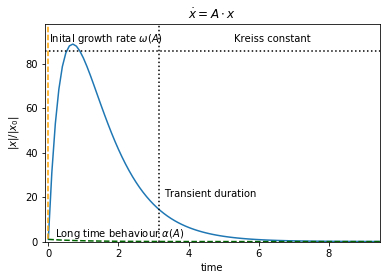

In [3]:
mcA = characterise_transient(A)
t=ivp.t
f, ax = plt.subplots()

plt.plot(ivp.t,spl.norm(ivp.y.T, axis=1)/spl.norm(x0))
ax.set_xlabel("time")
ax.set_ylabel(r'$|x|/|x_0|$')
ax.set_title(r'$\dot{x}=A\cdot x$')

ax.set_ylim((-.1,np.max(spl.norm(ivp.y.T, axis=1)/spl.norm(x0))*1.1))
t_trunc = t[np.where(t<mcA[3])]
ax.plot(t_trunc,np.exp(mcA[1]*t_trunc),"--",color="orange")
ax.plot(t, np.exp(mcA[0]*t),"--",color="darkgreen")
plt.axhline(y=mcA[2],linestyle="dotted",color="black")
if 3*mcA[3]<t[-1]:
    plt.axvline(x=mcA[3],linestyle="dotted",color="black")
    
ax.set_xlim((-.1, np.min([3*mcA[3],t[-1]])))
plt.annotate(r'Long time behaviour $\alpha (A)$',[1,1], [.2,2])
plt.annotate(r'Inital growth rate $\omega (A)$',[.01,90])
plt.annotate(r'Transient duration',[3.4,20], [3.3,20])
plt.annotate(r'Kreiss constant',[3.4,26], [5.3,90])

## Exponential growth

Suppose the system we are interested in grows exponentially in time. Then there is no meaning to a lower bound for a transient process, since the system will always saturate this bound at a large enough time.

/Users/rsingh/software/anaconda/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `args`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


Kreiss constant =  (2002896400+0j)


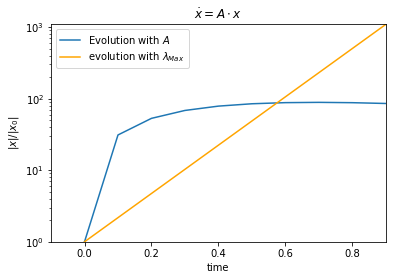

In [4]:
A2 = np.array([[3,2],[9,4]])
mcA2 =characterise_transient(A2)
print("Kreiss constant = ", mcA2[2])
x0 = [1,1]
tf = 1
ivp_exp = solve_ivp(linear_system, (0,tf), x0, args=[A2], t_eval=np.arange(0,tf,.1))

mc = characterise_transient(A2)
t=ivp_exp.t
f, ax = plt.subplots()

plt.plot(ivp_exp.t,spl.norm(ivp_exp.y.T, axis=1)/spl.norm(x0))
ax.set_xlabel("time")
ax.set_ylabel(r'$|x|/|x_0|$')
ax.set_title(r'$\dot{x}=A\cdot x$')

ax.set_ylim((-.1,np.max(spl.norm(ivp_exp.y.T, axis=1)/spl.norm(x0))*1.1))
t_trunc = t[np.where(t<mcA2[3])]
ax.set_xlim((-.1, np.min([3*mcA2[3],t[-1]])))
plt.yscale('log')
plt.autoscale(enable=True, axis='y', tight=True)
plt.plot(t,np.exp(mcA2[0]*t),color="orange")
plt.legend(["Evolution with $A$","evolution with $\lambda_{Max}$"])

The Kreiss constant $K_0 \approx 10^{16}$ doesn't give us any useful information. Is there any way to get a good estimate for the transient properties of this system? The answer is, in fact, yes. Consider the ratio of maximum transient growth to maximum regular growth $$\frac{e^{\boldsymbol{A}t}}{e^{\lambda_{\text{max}}t}}$$ This is the solution to the associated kinematical system $$\dot{x}=\left(\boldsymbol{A}-\lambda_{\text{max}}I\right)x = \Gamma x$$ If we now characterise the transients of $\Gamma$ we get:

Kreiss constant =  (1.292701+0j)


Text(3.53, 1.3, 'Kreiss constant $\\mathcal{K} (\\Gamma)$')

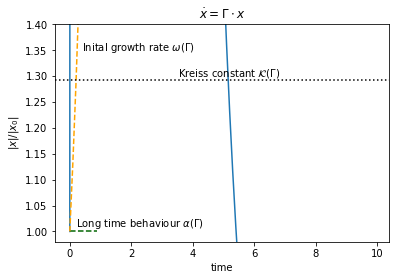

In [5]:
Gamma = A2 - np.max(spl.eigvals(A2))*np.identity(len(A2))
mcA2 = characterise_transient(Gamma)
print("Kreiss constant = ", mcA2[2])

x0 = [2,1]
tf = 10
ivp_exp2 = solve_ivp(linear_system, (0,tf), x0, args=[Gamma], t_eval=np.arange(0,tf,.1))
f, ax = plt.subplots()

plt.plot(ivp_exp2.t,spl.norm(ivp_exp2.y.T, axis=1)/spl.norm(x0))
ax.set_xlabel("time")
ax.set_ylabel(r'$|x|/|x_0|$')
ax.set_title(r'$\dot{x}=\Gamma\cdot x$')
ax.plot(t, np.exp(mcA2[0]*t),"--",color="darkgreen")
ax.set_ylim((-.1,np.max(spl.norm(ivp_exp2.y.T, axis=1)/spl.norm(x0))*1.1))
t_trunc = t[np.where(t<mcA2[3])]
ax.plot(t_trunc,np.exp(mcA2[1]*t_trunc),"--",color="orange")
plt.axhline(y=mcA2[2],linestyle="dotted",color="black")    

plt.ylim([.98,1.4])
plt.annotate(r'Long time behaviour $\alpha (\Gamma)$', [.2,1.01])
plt.annotate(r'Inital growth rate $\omega (\Gamma)$',[.4,1.35])
plt.annotate(r'Kreiss constant $\mathcal{K} (\Gamma)$', [3.53,1.3])

we see that now the Kreiss constant represents the maximum that the ratio $$\frac{e^{\boldsymbol{A}t}}{e^{\lambda_{\text{max}}t}}$$ can attain when optimised over the initial conditions. Thus, given the evolution equation
$$\dot{x}=\boldsymbol{A}x$$ we can write an approximate form of the solution as $$x(t) = \mathcal{K}\left(\boldsymbol{A}-\lambda_\text{max}I\right){e^{\lambda_{\text{max}}t}}x_0=\mathcal{K}\left(\Gamma\right){e^{\lambda_{\text{max}}t}}x_0$$ where the pair $\mathcal{K}$, $\lambda_{Max}$ characterise the initial growth.